# PROYECTO N°2: MACHINE LEARNING

###    DESCRIPCIÓN DEL PROYECTO

El presente archivo es el paso a paso para la obtención de un modelo de ML que tenga la capacidad de predecir si la estadía de un paciente en el hospital, será mayor a 8 días o menor o igual a 8 días.

In [1]:
# Importamos librerías que serán utilizadas
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm

### FEATURE ENGINEERING:

Importamos la data proporcionada y realizamos la exploración (EDA). Verificamos si los valores son categóricos o numéricos

In [2]:
#Importamos la data para su exploracion
datatrain = pd.read_csv('hospitalizaciones_train.csv')
datatrain.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


### EDA:
Exploramos cada columna

In [3]:
# Exploramos cada columna. Empezamos por la columna 1: Available 
# Extra Rooms in Hospital
datatrain.iloc[:,0].unique()

array([ 4,  2,  7,  3,  5, 10,  6,  1, 21,  8, 11, 13,  9, 14, 24,  0, 12,
       20], dtype=int64)

In [4]:
# Exploramos valores únicos para la columna 2: Department
datatrain.Department.unique()

array(['gynecology', 'anesthesia', 'TB & Chest disease', 'radiotherapy',
       'surgery'], dtype=object)

In [5]:
# Exploramos valores únicos para la columna 3: Ward_Facility_Code, codigo de
# habitacion del paciente
datatrain.Ward_Facility_Code.unique()

array(['D', 'B', 'E', 'F', 'A', 'C'], dtype=object)

In [6]:
# Exploramos valores únicos para la columna 4: doctor_name
datatrain.doctor_name.unique()

array(['Dr Sophia', 'Dr Olivia', 'Dr Mark', 'Dr John', 'Dr Sarah',
       'Dr Sam', 'Dr Nathan', 'Dr Simon', 'Dr Isaac'], dtype=object)

In [7]:
# Exploramos valores únicos para la columna 5: staff_available
datatrain.staff_available.unique()

array([ 0,  2,  8,  7, 10,  5,  9,  3,  6,  4,  1], dtype=int64)

In [8]:
# Exploramos valores únicos para la columna 6: patientid
datatrain.patientid.value_counts()

44572     18
125618    18
3635      17
126681    17
126170    17
          ..
106383     1
61225      1
77996      1
46153      1
63598      1
Name: patientid, Length: 122394, dtype: int64

In [9]:
# Exploramos valores únicos para la columna 7: Age
datatrain.Age.unique()

array(['41-50', '31-40', '21-30', '71-80', '11-20', '51-60', '61-70',
       '81-90', '91-100', '0-10'], dtype=object)

In [10]:
# Exploramos valores únicos para la columna 8: gender
datatrain.gender.unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [11]:
# Exploramos valores únicos para la columna 9: Type of Admission
datatrain.iloc[:,8].unique()

array(['Trauma', 'Urgent', 'Emergency'], dtype=object)

In [12]:
# Exploramos valores únicos para la columna 10: Severity of illness
datatrain.iloc[:,9].unique()

array(['Extreme', 'Minor', 'Moderate'], dtype=object)

In [13]:
# Exploramos valores únicos para la columna 11: health_conditions
datatrain.health_conditions.unique()

array(['Diabetes', 'Heart disease', 'None', 'Other', 'Asthama',
       'High Blood Pressure'], dtype=object)

In [14]:
# Exploramos valores únicos para la columna 12: Visitors with patient, cantidad
# de visitantes registrados para el paciente
datatrain.iloc[:,11].info()

<class 'pandas.core.series.Series'>
RangeIndex: 410000 entries, 0 to 409999
Series name: Visitors with Patient
Non-Null Count   Dtype
--------------   -----
410000 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [15]:
# Exploramos valores únicos para la columna 13: Insurance, si posee seguro o no
datatrain.Insurance.unique()

array(['Yes', 'No'], dtype=object)

In [16]:
# Exploramos valores únicos para la columna 14: Admission_Deposit. Verificaremos la
# relevancia del pago inicial realizado
datatrain.iloc[:,13].info()

<class 'pandas.core.series.Series'>
RangeIndex: 410000 entries, 0 to 409999
Series name: Admission_Deposit
Non-Null Count   Dtype  
--------------   -----  
410000 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


In [17]:
# Exploramos valores únicos para la columna 15: Stay, estancia hospitalaria
datatrain.iloc[:,14].info()

<class 'pandas.core.series.Series'>
RangeIndex: 410000 entries, 0 to 409999
Series name: Stay (in days)
Non-Null Count   Dtype
--------------   -----
410000 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


## FEATURE ENCODING:

Las columnas que poseen datos categóricos, los convertimos a numéricos

In [18]:
# Convertimos los dias de la columna "stay" a 1 para un permanencia mayor a 8 días y 0
# para dias menores o igual a 8.
bins = [-1,8,100]
labels = [0,1]
permanencia = pd.cut(datatrain["Stay (in days)"], bins , labels = labels)
datatrain["Stay"] = permanencia
datatrain.head(3)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days),Stay
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8,0
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9,1
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7,0


In [19]:
# Observamos que la columna "Stay" de 1s y 0s es tipo categoría, por lo tanto, lo
# convertimos a int
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Available Extra Rooms in Hospital  410000 non-null  int64   
 1   Department                         410000 non-null  object  
 2   Ward_Facility_Code                 410000 non-null  object  
 3   doctor_name                        410000 non-null  object  
 4   staff_available                    410000 non-null  int64   
 5   patientid                          410000 non-null  int64   
 6   Age                                410000 non-null  object  
 7   gender                             410000 non-null  object  
 8   Type of Admission                  410000 non-null  object  
 9   Severity of Illness                410000 non-null  object  
 10  health_conditions                  410000 non-null  object  
 11  Visitors with Patient     

In [20]:
# Verificamos que la columna "Stay" es tipo "int"
datatrain["Stay"]=pd.factorize(datatrain["Stay"])[0]
datatrain.Stay.info()

<class 'pandas.core.series.Series'>
RangeIndex: 410000 entries, 0 to 409999
Series name: Stay
Non-Null Count   Dtype
--------------   -----
410000 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


COLUMNA 1: Available Extra Rooms in Hospital: Habitaciones adicionales disponibles en el hospital. Una habitación no es igual a un paciente, pueden ser individuales o compartidas.

In [21]:
# En todo hospital podremos observar habitaciones mejores equipadas que otras, por lo cual, es importante
# considerar esta columna, ya que, al momento de ingresar al paciente una gran cantidad de habitaciones disponibles
# dará la libertad de seleccionar la habitación más adecuada para el paciente.
datatrain["Extra_Room"]=datatrain["Available Extra Rooms in Hospital"]

COLUMNA 2: Department: Área de atención a la que ingresa el paciente.

In [22]:
# Se realiza OneHotEncoder para la colummna "Department", es importante tener 
# mapeado el departamento al cual ingresa el paciente.

enc = OneHotEncoder(sparse=False)
departamentos=datatrain["Department"].values.reshape(-1,1)
enc.fit(departamentos)
enc2=enc.transform(departamentos)
print(enc.categories_)
datatrain["Department_TB & Chest disease"]=enc2[:,0]
datatrain["Department_anesthesia"]=enc2[:,1]
datatrain["Department_gynecology"]=enc2[:,2]
datatrain["Department_radiotherapy"]=enc2[:,3]
datatrain["Department_surgery"]=enc2[:,4]


[array(['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy',
       'surgery'], dtype=object)]


COLUMNA 3: Ward_Facility_Code: Código de la habitación del paciente.

In [23]:
# La habitación en la cual se encuentra el paciente puede tener repercusiones
# en  su pronta recuperación. No es lo mismo, encontrarse en una habitación con baja
# iluminación que una con mayor iluminación y con mejor vista.
hab_enc = LabelEncoder().fit(datatrain['Ward_Facility_Code'])
datatrain["Cod_Hab"] = hab_enc.transform(datatrain['Ward_Facility_Code'])

COLUMNA 4: doctor_name: Nombre de el/la doctor/a a cargo del paciente.

In [24]:
# Considero que, la experiencia de cada médico es un factor muy 
# importante a la hora de emitir diagnósticos y tratamientos 
# más acertados para cada paciente en este hospital.
# Por lo tanto, se realiza OneHotEncoder para obtener valores númericos.

enc = OneHotEncoder(sparse=False)
doctor=datatrain["doctor_name"].values.reshape(-1,1)
enc.fit(doctor)
enc2=enc.transform(doctor)
print(enc.categories_)
datatrain["Dr Isaac"]=enc2[:,0]
datatrain["Dr John"]=enc2[:,1]
datatrain["Dr Mark"]=enc2[:,2]
datatrain["Dr Nathan"]=enc2[:,3]
datatrain["Dr Olivia"]=enc2[:,4]
datatrain["Dr Sam"]=enc2[:,5]
datatrain["Dr Sarah"]=enc2[:,6]
datatrain["Dr Simon"]=enc2[:,7]
datatrain["Dr Sophia"]=enc2[:,8]


[array(['Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia',
       'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia'], dtype=object)]


COLUMNA 5: staff_available: Cantidad de personal disponible al momento del ingreso del paciente.

In [25]:
# Considero que, es importante la rapidez con la que un
# paciente es atendido al momento de ingresar al hospital. Por esta
# razón hacemos un label para cuando no hay personal(0) y para
# cuando si hay personal (1) 

bins=[-1,0,10]
labels=[0,1]
staff=pd.cut(datatrain["staff_available"],bins, labels = labels)
datatrain["Staff"]=staff
datatrain["Staff"]=pd.factorize(datatrain['Staff'])[0]

COLUMNA 6: patientid: Identificador del paciente.

In [26]:
# Se ha observado que hay pacientes que regresan más de 1 vez al hospital, por lo tanto, vamos a considerar
# esta columna.
datatrain["id"]=datatrain["patientid"]

COLUMNA 7: Age: Edad del paciente.

In [27]:
# Es un parámetro muy relevante, ya que, las personas jóvenes se 
# recuperan más rápido que los adultos y adultos mayores

age_enc = LabelEncoder().fit(datatrain['Age'])
datatrain["Label_age"] = age_enc.transform(datatrain['Age'])


COLUMNA 8: gender: Género del paciente.

In [28]:
# El género biológico es importante, ya que, existen diferencias
# a nivel molecular que tienen significancia en la recuperación.

enc = OneHotEncoder(sparse=False)
genero=datatrain["gender"].values.reshape(-1,1)
enc.fit(genero)
enc2=enc.transform(genero)
print(enc.categories_)
datatrain["Female_encoded"]=enc2[:,0]
datatrain["Male_encoded"]=enc2[:,1]
datatrain["Other_encoded"]=enc2[:,2]


[array(['Female', 'Male', 'Other'], dtype=object)]


COLUMNA 9: Type of Admission: Tipo de ingreso registrado según la situación de ingreso del paciente.

In [29]:
# La situación del paciente ingresado es un factor
# determinante en su tiempo de recuperación, y en consecuencia, 
# con el tiempo de permanencia.

enc = OneHotEncoder(sparse=False)
admision=datatrain["Type of Admission"].values.reshape(-1,1)
enc.fit(admision)
enc2=enc.transform(admision)
print(enc.categories_)
datatrain["Emergency"]=enc2[:,0]
datatrain["Trauma"]=enc2[:,1]
datatrain["Urgente"]=enc2[:,2]  

[array(['Emergency', 'Trauma', 'Urgent'], dtype=object)]


COLUMNA 10: Severity of Illness: Gravedad de la enfermedad/condición/estado del paciente al momento del ingreso.

In [30]:
# La gravedad de la situacion del paciente ingresado es un factor
# determinante en su tiempo de recuperación, y en consecuencia, 
# en el tiempo de permanencia.
enc = OneHotEncoder(sparse=False)
severidad=datatrain["Severity of Illness"].values.reshape(-1,1)
enc.fit(severidad)
enc2=enc.transform(severidad)
print(enc.categories_)
datatrain["Extreme"]=enc2[:,0]
datatrain["Minor"]=enc2[:,1]
datatrain["Moderate"]=enc2[:,2]

[array(['Extreme', 'Minor', 'Moderate'], dtype=object)]


COLUMNA 11: health_conditions: Condiciones de salud del paciente.

In [31]:
# Enfermedades como la diabetes ralentizan la recuperación normal de las personas,
# por lo cual, se considera la condiciones de salud.
enc = OneHotEncoder(sparse=False)
condicion=datatrain["health_conditions"].values.reshape(-1,1)
enc.fit(condicion)
enc2=enc.transform(condicion)
print(enc.categories_)
datatrain["Asthama"]=enc2[:,0]
datatrain["Diabetes"]=enc2[:,1]
datatrain["Heart disease"]=enc2[:,2]
datatrain["High Blood Pressure"]=enc2[:,3]
datatrain["None"]=enc2[:,4]
datatrain["Other"]=enc2[:,5]


[array(['Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure',
       'None', 'Other'], dtype=object)]


COLUMMNA 12: Visitors with Patient: Cantidad de visitantes registrados para el paciente.

In [32]:
# Considero que, las visitas por parte de familiares puede generar un sentimiento
# reconfortante y así evitar el sentir de abandono y soledad.

# La cantidad de visitas puede ser un factor importante en la 
# pronta recuperación del paciente
datatrain["Visitas"]=datatrain["Visitors with Patient"]

COLUMMNA 13: Insurance: Indica si la persona posee o no seguro de salud.

In [33]:
# Convertimos a 1s y 0s según exista seguro o no. Estar asegurado, puede ayudar a solventar gastos imprevistos de manera más rápida

age_enc = LabelEncoder().fit(datatrain['Insurance'])
datatrain["Seguro"] = age_enc.transform(datatrain['Insurance'])

COLUMNA 14: Admission_Deposit: Pago realizado a nombre del paciente, con el fin de cubrir los costos iniciales de internación.

In [34]:
# Financiamiento importante para paliar los gastos por algun imprevisto o necesidad.
datatrain["Depos"]=datatrain["Admission_Deposit"]

SE ELIMINAN COLUMNAS QUE NO USAREMOS
- Mostrar columnas: pd.options.display.max_columns = None

In [35]:
# Eliminamos columnas cambiadas
data_total=datatrain.drop(columns=list(datatrain.columns)[0:15])

In [36]:
# Generamos la datax sin la columna "Stay"
data_x=data_total.drop(columns=["Stay"])


In [37]:
# Generamos la datay
data_y=data_total["Stay"]

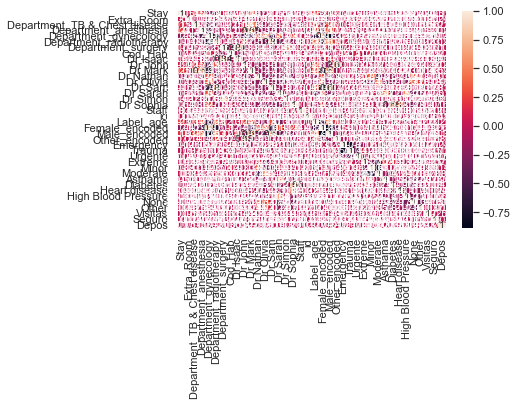

In [38]:
# Generamos un heatmap para verificar las correlaciones
corr = data_total.corr()
sns.set(rc = {'figure.figsize':(40,40)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True);

## REPETIMOS EL PROCESO CON LA DATA_TEST:

Realizamos los mismos pasos que para la datatrain

In [39]:
data_test = pd.read_csv('hospitalizaciones_test.csv')

In [40]:
data_test["Extra_Room"]=data_test["Available Extra Rooms in Hospital"]

In [41]:
enc = OneHotEncoder(sparse=False)
departamentos=data_test["Department"].values.reshape(-1,1)
enc.fit(departamentos)
enc2=enc.transform(departamentos)
print(enc.categories_)
data_test["Department_TB & Chest disease"]=enc2[:,0]
data_test["Department_anesthesia"]=enc2[:,1]
data_test["Department_gynecology"]=enc2[:,2]
data_test["Department_radiotherapy"]=enc2[:,3]
data_test["Department_surgery"]=enc2[:,4]

[array(['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy',
       'surgery'], dtype=object)]


In [42]:
hab_enc = LabelEncoder().fit(data_test['Ward_Facility_Code'])
data_test["Cod_Hab"] = hab_enc.transform(data_test['Ward_Facility_Code'])

In [43]:
enc = OneHotEncoder(sparse=False)
doctor=data_test["doctor_name"].values.reshape(-1,1)
enc.fit(doctor)
enc2=enc.transform(doctor)
print(enc.categories_)
data_test["Dr Isaac"]=enc2[:,0]
data_test["Dr John"]=enc2[:,1]
data_test["Dr Mark"]=enc2[:,2]
data_test["Dr Nathan"]=enc2[:,3]
data_test["Dr Olivia"]=enc2[:,4]
data_test["Dr Sam"]=enc2[:,5]
data_test["Dr Sarah"]=enc2[:,6]
data_test["Dr Simon"]=enc2[:,7]
data_test["Dr Sophia"]=enc2[:,8]

[array(['Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia',
       'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia'], dtype=object)]


In [44]:
bins=[-1,0,10]
labels=[0,1]
staff=pd.cut(data_test["staff_available"],bins, labels = labels)
data_test["Staff"]=staff
data_test["Staff"]=pd.factorize(data_test['Staff'])[0]

In [45]:
data_test["id"]=data_test["patientid"]

In [46]:
age_enc = LabelEncoder().fit(data_test['Age'])
data_test["Label_age"] = age_enc.transform(data_test['Age'])

In [47]:
enc = OneHotEncoder(sparse=False)
genero=data_test["gender"].values.reshape(-1,1)
enc.fit(genero)
enc2=enc.transform(genero)
print(enc.categories_)
data_test["Female_encoded"]=enc2[:,0]
data_test["Male_encoded"]=enc2[:,1]
data_test["Other_encoded"]=enc2[:,2]

[array(['Female', 'Male', 'Other'], dtype=object)]


In [48]:
enc = OneHotEncoder(sparse=False)
admision=data_test["Type of Admission"].values.reshape(-1,1)
enc.fit(admision)
enc2=enc.transform(admision)
print(enc.categories_)
data_test["Emergency"]=enc2[:,0]
data_test["Trauma"]=enc2[:,1]
data_test["Urgente"]=enc2[:,2]

[array(['Emergency', 'Trauma', 'Urgent'], dtype=object)]


In [49]:
enc = OneHotEncoder(sparse=False)
severidad=data_test["Severity of Illness"].values.reshape(-1,1)
enc.fit(severidad)
enc2=enc.transform(severidad)
print(enc.categories_)
data_test["Extreme"]=enc2[:,0]
data_test["Minor"]=enc2[:,1]
data_test["Moderate"]=enc2[:,2]

[array(['Extreme', 'Minor', 'Moderate'], dtype=object)]


In [50]:
enc = OneHotEncoder(sparse=False)
condicion=data_test["health_conditions"].values.reshape(-1,1)
enc.fit(condicion)
enc2=enc.transform(condicion)
print(enc.categories_)
data_test["Asthama"]=enc2[:,0]
data_test["Diabetes"]=enc2[:,1]
data_test["Heart disease"]=enc2[:,2]
data_test["High Blood Pressure"]=enc2[:,3]
data_test["None"]=enc2[:,4]
data_test["Other"]=enc2[:,5]

[array(['Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure',
       'None', 'Other'], dtype=object)]


In [51]:
data_test["Visitas"]=data_test["Visitors with Patient"]

In [52]:
age_enc = LabelEncoder().fit(data_test['Insurance'])
data_test["Seguro"] = age_enc.transform(data_test['Insurance'])

In [53]:
data_test["Depos"]=data_test["Admission_Deposit"]

ELIMINAMOS COLUMNAS SIN USO

In [54]:
data_totalT=data_test.drop(columns=list(data_test.columns)[0:14])

## ENTRENAMIENTO Y MODELADO DE LA DATA:

Seleccionamos un 70% de la data para generar nuestra muestra de entrenamiento

In [55]:
from sklearn.model_selection import train_test_split
# Dejamos 30% de data para entrenamiento
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.30, random_state=42)

### 1. REGRESIÓN LOGÍSTICA

In [56]:
# Importamos la clase que contiene el algoritmo de regresíon logística

from sklearn.linear_model import LogisticRegression

# Instanciamos el modelo y lo entrenamos

clf1 = LogisticRegression()

# Lo entrenamos

clf1.fit(x_train,y_train)

LogisticRegression()

In [57]:
from sklearn.metrics import accuracy_score 

# Predecimos

y_pred1 = clf1.predict(x_test)

# Evaluamos

print('Accuracy del modelo es:', accuracy_score(y_test, y_pred1))
print('Recall del modelo es:', recall_score(y_test, y_pred1))

Accuracy del modelo es: 0.6223008130081301
Recall del modelo es: 1.0


### 2. VECINOS MÁS CERCANOS

In [58]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciamos un objeto de la clase KNeighborsClassifier

clf2 = KNeighborsClassifier()

In [59]:
# Entrenamos

clf2.fit(x_train,y_train)

KNeighborsClassifier()

In [60]:
# Predecimos
y_pred2 = clf2.predict(x_test)

In [61]:
# Evaluamos
print("El accuracy del modelo es: ", accuracy_score(y_test,y_pred2))
print("El recall del modelo es: ", recall_score(y_test,y_pred2))

El accuracy del modelo es:  0.562780487804878
El recall del modelo es:  0.7222084318618293


### 3. ÁRBOL DE DECISIÓN

In [62]:
from sklearn.tree import DecisionTreeClassifier
# Instanciamos el árbol
tree0 = DecisionTreeClassifier(max_depth = None)
tree0.fit(x_train, y_train)

DecisionTreeClassifier()

In [63]:
# Predecimos
y0 = tree0.predict(x_test)
# Evaluamos
print("El accuracy del modelo es: ", accuracy_score(y_test,y0))
print("El recall del modelo es: ", recall_score(y_test,y0))

El accuracy del modelo es:  0.7582113821138211
El recall del modelo es:  0.8041362371477471


### SELECCIÓN DEL MEJOR MODELO:

El mejor modelo es generado con el árbol de decisión. Procedemos a generar el archivo "pred"

In [64]:
# Predecimos para la data_test
y0test = tree0.predict(data_totalT)

In [65]:
# Generamos el dataframe con los valores obtenidos
y0test_csv=pd.DataFrame(list(y0test),columns=["pred"])

In [66]:
# Verificamos que posea los 90000 registros
y0test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pred    90000 non-null  int64
dtypes: int64(1)
memory usage: 703.2 KB


In [67]:
# Creamos el archivo "csv"
y0test_csv.to_csv("pred/rafael1294.csv",index=False)